In [5]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from pathlib import Path

In [22]:
train_path = Path.cwd().parent.joinpath('data/semeval-2016/train.csv')
test_path = Path.cwd().parent.joinpath('data/semeval-2016/test.csv')
print(train_path)
print(test_path)

/Users/smap10/Project/aspect-extraction/data/semeval-2016/train.csv
/Users/smap10/Project/aspect-extraction/data/semeval-2016/test.csv


In [23]:
# Read data
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

In [24]:
data_train.tail()

,Sentence #,Tag,Word
28641,2000,O,would
28642,2000,O,retrain
28643,2000,O,the
28644,2000,B,staff
28645,2000,O,.


In [25]:
data_test.tail()

,Sentence #,Tag,Word
9864,676,O,was
9865,676,O,good
9866,676,O,","
9867,676,O,too
9868,676,O,.


In [127]:
data = data_train

# Save all words as a list
words = list(set(data['Word'].values))
n_words = len(words)

tags = list(set(data["Tag"].values))
n_tags = len(tags)

max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
n_words = len(word2idx)
# word2idx['<unk>'] = len(word2idx) + 1
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18


# Sentence class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences

max_len = 75
word2idx = {w: i + 1 for i, w in enumerate(words)}
n_words = len(word2idx)
# word2idx['<unk>'] = len(word2idx) + 1
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx['<pad>'] = 0
n_tags = len(tag2idx) # Due to <pad>, here total tag number is from 17 to 18

# Word2inx & Padding for X
X = [[word2idx[w[0]] for w in s] for s in sentences]
X_train = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_train = [to_categorical(i, num_classes=n_tags) for i in y]

In [129]:
print(len(X_train))
print(len(y_train))

2000
2000


In [130]:
#==============Bi-LSTM CRF=============
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="tanh"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 75)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 75, 20)            72000     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_10 (TimeDis (None, 75, 50)            5050      
_________________________________________________________________
crf_10 (CRF)                 (None, 75, 4)             228       
Total params: 105,678
Trainable params: 105,678
Non-trainable params: 0
_________________________________________________________________


In [132]:
history = model.fit(X_train, np.array(y_train), batch_size=32, epochs=8,
                    validation_split=0.1, verbose=1)

Train on 1800 samples, validate on 200 samples
Epoch 1/8
1800/1800 [==============================] - 10s 6ms/step - loss: 10.2801 - acc: 0.8099 - val_loss: 10.1782 - val_acc: 0.9190
Epoch 2/8
1800/1800 [==============================] - 6s 3ms/step - loss: 10.0469 - acc: 0.8953 - val_loss: 10.0821 - val_acc: 0.9180
Epoch 3/8
1800/1800 [==============================] - 6s 3ms/step - loss: 9.9476 - acc: 0.9063 - val_loss: 10.0452 - val_acc: 0.9194
Epoch 4/8
1800/1800 [==============================] - 7s 4ms/step - loss: 9.9079 - acc: 0.9172 - val_loss: 10.0282 - val_acc: 0.9246
Epoch 5/8
1800/1800 [==============================] - 7s 4ms/step - loss: 9.8839 - acc: 0.9253 - val_loss: 10.0313 - val_acc: 0.9255
Epoch 6/8
1800/1800 [==============================] - 6s 4ms/step - loss: 9.8666 - acc: 0.9326 - val_loss: 10.0251 - val_acc: 0.9281
Epoch 7/8
1800/1800 [==============================] - 6s 3ms/step - loss: 9.8529 - acc: 0.9368 - val_loss: 10.0362 - val_acc: 0.9261
Epoch 8/8
18

In [134]:
hist = pd.DataFrame(history.history)

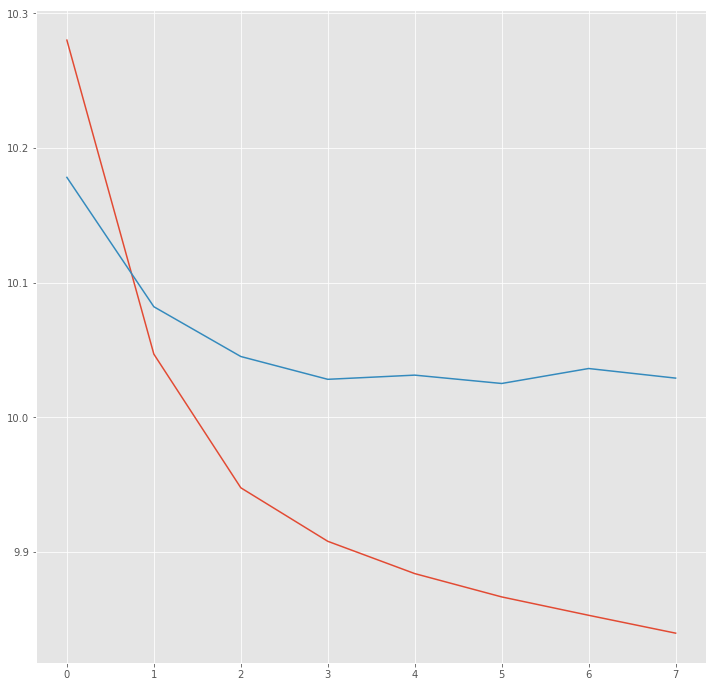

In [135]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

# predict on test dataset

In [136]:
data = data_test

# Sentence class
class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
#                                                            s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sentences = getter.sentences # get all sentences
   
# Word2inx & Padding for X
X = [[word2idx.get(w[0], 0) for w in s] for s in sentences]
X_test = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)

# Word2inx & Padding for y
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=0)

# Get one-hot labels
y_test = [to_categorical(i, num_classes=n_tags) for i in y]

In [137]:
print(sentences[1])
print(X_test[1])
print(np.argmax(y_test[1], -1))

[('serves', 'O'), ('really', 'O'), ('good', 'O'), ('sushi', 'B'), ('.', 'O')]
[1183 3401 2591  176 1280    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[1 1 1 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


In [153]:
# Predictions.
idx2word = {value: key for key, value in word2idx.items()}
idx2tag = {value: key for key, value in tag2idx.items()}


true_all = np.argmax(y_test, -1)

true_all_tags = [[idx2tag[idx] for idx in s if idx!=0] for s in true_all]

p_all = model.predict(np.array(X_test)) # (4796, 75, 18)
p_all= np.argmax(p_all, axis=-1) # (4796, 75)
p_all_tags = [[idx2tag[idx] for idx in s] for s in p_all] # ['B-gpe', 'O', 'O', 'O']

for i, true in enumerate(true_all_tags):
    length = len(true)
    p_all_tags[i] = p_all_tags[i][:length]

p_all_tags = [[x.replace('<pad>', 'O') for x in s] for s in p_all_tags]

# for (true_tag, p)

print(sentences[3])
print(X_test[3])
print(true_all_tags[3])
print(p_all_tags[3])

[('green', 'B'), ('tea', 'I'), ('creme', 'I'), ('brulee', 'I'), ('is', 'O'), ('a', 'B'), ('must', 'O'), ('!', 'O')]
[3286 1088    0    0  539 2177 3012 3425    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
['B', 'I', 'I', 'I', 'O', 'B', 'O', 'O']
['I', 'I', 'O', 'O', 'O', 'O', 'O', 'O']


In [154]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(sentences[3], true_all_tags[3], p_all_tags[3]):
    if w != 0:
        print("{:15}: {:5} {}".format(w[0], w[1], pred))


Word           ||True ||Pred
green          : B     I
tea            : I     I
creme          : I     O
brulee         : I     O
is             : O     O
a              : B     O
must           : O     O
!              : O     O


In [155]:
# Evaluation
from seqeval.metrics import f1_score, classification_report
print(f1_score(true_all_tags, p_all_tags))
print(classification_report(true_all_tags, p_all_tags))


0.41892832289492
             precision    recall  f1-score   support

          B       0.58      0.34      0.42       599
          I       0.45      0.37      0.41       269

avg / total       0.54      0.35      0.42       868

